<a href="https://colab.research.google.com/github/alzaidawi/PORTAL_code/blob/main/test_labling_pores_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## The training and test image paths
from skimage.io import imread, imshow
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import time
from google.colab.patches import cv2_imshow
import os

train_features_path =  "train_pixels_features_and_lables.csv"
test_features_path =  "test_pixels_features_and_lables.csv"

def extract_pixel_features(input_image):
  #load the image
  img_org = input_image  ## incase I train with multi images

  print('orginal image')
  print('img.shape',img_org.shape)
  cv2_imshow(img_org)

  # convert the image to gray scal
  img = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)
  print('gray image')
  print('gray image.shape',img.shape)
  cv2_imshow(img)


  img2 = img.reshape(-1) ## reshape the image into single column
  print('img converted to one column',img2.shape)
  df = pd.DataFrame()
  t0 = time.time()   ## starting time

  df['Original Image'] = img2


  #CANNY EDGE
  edges = cv2.Canny(img, 100,200)   #Image, min and max values
  edges1 = edges.reshape(-1)
  df['Canny Edge'] = edges1 #Add column to original dataframe

  from skimage.filters import roberts, sobel, scharr, prewitt

  #ROBERTS EDGE
  edge_roberts = roberts(img)
  edge_roberts1 = edge_roberts.reshape(-1)
  df['Roberts'] = edge_roberts1

  #SOBEL
  edge_sobel = sobel(img)
  edge_sobel1 = edge_sobel.reshape(-1)
  df['Sobel'] = edge_sobel1

  #SCHARR
  edge_scharr = scharr(img)
  edge_scharr1 = edge_scharr.reshape(-1)
  df['Scharr'] = edge_scharr1

  #PREWITT
  edge_prewitt = prewitt(img)
  edge_prewitt1 = edge_prewitt.reshape(-1)
  df['Prewitt'] = edge_prewitt1

  Kernal_size = 3

  #GAUSSIAN with sigma=3
  from scipy import ndimage as nd
  gaussian_img = nd.gaussian_filter(img, sigma=5)
  gaussian_img1 = gaussian_img.reshape(-1)
  df['Gaussian s3'] = gaussian_img1

  #GAUSSIAN with sigma=7
  gaussian_img2 = nd.gaussian_filter(img, sigma=7)
  gaussian_img3 = gaussian_img2.reshape(-1)
  df['Gaussian s7'] = gaussian_img3

  #MEDIAN with sigma=3
  median_img = nd.median_filter(img, size=Kernal_size)
  median_img1 = median_img.reshape(-1)
  df['Median s3'] = median_img1

  #VARIANCE with size=3
  variance_img = nd.generic_filter(img, np.var, size=Kernal_size)
  variance_img1 = variance_img.reshape(-1)
  df['Variance s3'] = variance_img1  #Add column to original dataframe

  feat_ext_time = time.time()-t0
  local_time_feature_rxtraction = time.localtime(feat_ext_time)

  # show some pf the feature images
  import matplotlib.pyplot as plt
  fig, axes = plt.subplots(1, 5, figsize=(10,10))
  print('input image',img.shape)
  print('gray image',img2.shape)

  axes[0].imshow(np.asanyarray(df['Original Image']).reshape(img.shape), cmap=plt.cm.gray)
  axes[1].imshow(np.asanyarray(df['Canny Edge']).reshape(img.shape), cmap=plt.cm.gray)
  axes[2].imshow(np.asanyarray(df['Roberts']).reshape(img.shape), cmap=plt.cm.gray)
  axes[3].imshow(np.asanyarray(df['Sobel']).reshape(img.shape), cmap=plt.cm.gray)
  axes[4].imshow(np.asanyarray(df['Scharr']).reshape(img.shape), cmap=plt.cm.gray)

  # show some pf the feature images
  fig, axes = plt.subplots(1, 5, figsize=(10,10))

  axes[0].imshow(np.asanyarray(df['Prewitt']).reshape(img.shape), cmap=plt.cm.gray)
  axes[1].imshow(np.asanyarray(df['Gaussian s3']).reshape(img.shape), cmap=plt.cm.gray)
  axes[2].imshow(np.asanyarray(df['Gaussian s7']).reshape(img.shape), cmap=plt.cm.gray)
  axes[3].imshow(np.asanyarray(df['Median s3']).reshape(img.shape), cmap=plt.cm.gray)
  axes[4].imshow(np.asanyarray(df['Variance s3']).reshape(img.shape), cmap=plt.cm.gray)

  # return img, img_org, df
  return img, df



In [2]:

## Note: to save correct masks use png as extention for the input and output.
def label_image(img,img_org, output_labeled_image_path, features_csv, df ):
  # Threshold the image to obtain binary image
  ## https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html

  ret, binary = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)   ## check from here
  # Find contours in the binary image
  print('the binary image')
  print('binary shape', binary.shape)
  cv2_imshow(binary)

  contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  # print("hierarchy", hierarchy)

  print('len main contours', len(contours))
  #max_cnt = max(contours, key = cv2.contourArea)

  # ######################### new code
  #max_area = cv2.contourArea(max_cnt)
  circularities_all_pores =[]
  solidity_all_pores = []
  cnt_area_list = []
  convexity_all_pores=[]
  for f, contour in enumerate(contours):
      cnt_rect = cv2.minAreaRect(contour)
      cnt_area = cv2.contourArea(contour)
      cnt_area_list.append(cnt_area)

  print('cnt_area_list',cnt_area_list)
  #area_list = [item for item in cnt_area_list if item < max_area]
  #area_list_1 = [item for item in area_list if item > 0]
  #median_area = np.median(area_list_1)

  # area_list_2 = [item for item in area_list_1 if item < median_area]
  # print('area after take the second median', area_list_2)
  # median_area_2 = np.median(area_list_2)
  # mean_area_2 = np.mean(area_list_2)
  # std_area_2 = np.std(area_list_2)
  # mean_minus_sd = mean_area_2 - 3*std_area_2
  # area_mean_plus_sd = mean_area_2 + 3*std_area_2
  # print('max_area_2',np.max(area_list_2))
  # print('min_area_2',np.min(area_list_2))
  # print('median_area_2',median_area_2)
  # print('mean_area_2',mean_area_2)
  # print('std_area_2',std_area_2)
  # print('mean_minus_sd',mean_minus_sd)
  # print('area_mean_plus_sd',area_mean_plus_sd)
  # print('count_process_pores',len(area_list_2))
  area_mean_plus_sd = 87
  ######################### new code
  # Create an empty binary mask for each contour
  masks = [np.zeros(binary.shape, dtype=np.uint8) for _ in contours]
  count_no_child = []
  count_with_child = []

  count_LOF = []
  unique_lists = []
  count_keyhole = []
  count_process = []

  # Loop through each contour
  covexity_process_pore=[]  #new
  covexity_gas_pore=[]  #new
  covexity_crack_pore=[]  #new
  covexity_LOF_pore=[]  #new
  covexity_unmelted_pore=[]  #new

  solidity_process_pore=[]
  solidity_gas_pore=[]
  solidity_crack_pore=[]
  solidity_LOF_pore=[]
  solidity_unmelted_pore=[]

  process_total_pore_area = 0  ## new for position
  Gas_total_pore_area = 0  ## new for position
  crack_total_pore_area = 0  ## new for position
  LOF_total_pore_area = 0  ## new for position

  process_pore_com_x = 0  ## new for position
  process_pore_com_y = 0  ## new for position

  Gas_pore_com_x = 0  ## new for position
  Gas_pore_com_y = 0  ## new for position

  crack_pore_com_x = 0  ## new for position
  crack_pore_com_y = 0  ## new for position

  LOF_pore_com_x = 0  ## new for position
  LOF_pore_com_y = 0  ## new for position
  for i, cnt in enumerate(contours):
    moments = cv2.moments(cnt)  ## new for position
    if moments['m00'] != 0:  ## new for position
      pore_center_x = int(moments['m10']/moments['m00']) ## new for position
      pore_center_y = int(moments['m01']/moments['m00']) ## new for position
      rect = cv2.minAreaRect(cnt)
      area = cv2.contourArea(cnt)
      ############### new
      hull_a = cv2.convexHull(cnt)
      # Calculate the convexity of the contour
      hull_area = cv2.contourArea(hull_a)
      convexity = hull_area / area
      solidity = float(area)/hull_area
      solidity_all_pores.append(solidity)
      convexity_all_pores.append(convexity)

      perimeter = cv2.arcLength(cnt, True)
      pore_circularities = 4 * np.pi * (area / (perimeter * perimeter))
      circularities_all_pores.append(pore_circularities)
      ############### new
      (cx, cy), (w, h), angle = rect # No conversion required in the aspect ratio the unit divided
      aspect_ratio = max(w, h) / min(w, h)
      #print("aspect ratio", aspect_ratio)
      #print("pore_circularities", pore_circularities)

      # Get the type of the contour
      # print("i = ", i)
      if area > 0 and area < area_mean_plus_sd: # check by ploting which is having high %: 1sigma %, 2sgma %, 3sigma %
        covexity_process_pore.append(convexity) # new
        solidity_process_pore.append(solidity) # new
        annotation = 1 # process pore red color
        count_process.append(1)
        # print("Red i = ", i)
        process_pore_com_x = process_pore_com_x + pore_center_x*area  ## new for position
        process_pore_com_y = process_pore_com_y + pore_center_y*area  ## new for position
        process_total_pore_area = process_total_pore_area + area
      elif (pore_circularities >=  0.80 and area > area_mean_plus_sd) or (convexity > 0.99 and convexity < 1.06):
        annotation = 2 ## Gas pore (circle) green color
        count_keyhole.append(1)
        covexity_gas_pore.append(convexity) # new
        solidity_gas_pore.append(solidity) # new
        Gas_pore_com_x = Gas_pore_com_x + pore_center_x*area  ## new for position
        Gas_pore_com_y = Gas_pore_com_y + pore_center_y*area  ## new for position
        Gas_total_pore_area = Gas_total_pore_area + area
      elif aspect_ratio >= 3.5 and pore_circularities < 0.35 and convexity < 0.35:
        annotation = 3 ## (1) crack pore (line) yellow color
        covexity_crack_pore.append(convexity) # new
        solidity_crack_pore.append(solidity) # new
        # crack_pore_com_x = crack_pore_com_x + pore_center_x*area  ## new for position
        # crack_pore_com_y = crack_pore_com_y + pore_center_y*area  ## new for position
        # crack_total_pore_area = crack_total_pore_area + area
      else:
        annotation = 4   ## blue color  (LOF pores)
        count_LOF.append(1)
      covexity_LOF_pore.append(convexity) # new
      solidity_LOF_pore.append(solidity) # new
      LOF_pore_com_x = LOF_pore_com_x + pore_center_x*area  ## new for position
      LOF_pore_com_y = LOF_pore_com_y + pore_center_y*area  ## new for position
      LOF_total_pore_area = LOF_total_pore_area + area
    # else: # Check if the contour is a pore (with child contours)
    #     count_with_child.append(1)
    #     annotation = 4   ## blue color  (LOF pores)
    #     LOF_pore_com_x = LOF_pore_com_x + pore_center_x*area  ## new for position
    #     LOF_pore_com_y = LOF_pore_com_y + pore_center_y*area  ## new for position
    #     LOF_total_pore_area = LOF_total_pore_area + area

      # Fill the mask with the annotation value
      cv2.drawContours(masks[i], [cnt], 0, annotation, -1)
      cv2.drawContours(masks[i], [cnt], 0, 0, 1)  # Add class 0 label (black border),  last parameter is the thickness of the contour crack (line) to be drawn
  print('all pores convexity',convexity_all_pores)
  ################## new
  if process_total_pore_area != 0:
    process_pore_com_x = process_pore_com_x/process_total_pore_area
    process_pore_com_y = process_pore_com_y/process_total_pore_area
    print('saharrrrrrrr process_total_pore_area', process_total_pore_area)
    print(' process pore_com x',int(process_pore_com_x))
    print(' process pore_com y', int(process_pore_com_y))

  else:
    process_pore_com_x = 0
    process_pore_com_y = 0
  if Gas_total_pore_area != 0:
    Gas_pore_com_x = Gas_pore_com_x/Gas_total_pore_area
    Gas_pore_com_y = Gas_pore_com_y/Gas_total_pore_area
    print(' Gas pore_com x',int(Gas_pore_com_x))
    print(' Gas pore_com y', int(Gas_pore_com_y))
  else:
    Gas_pore_com_x = 0
    Gas_pore_com_y = 0
  # if crack_total_pore_area != 0:
    # crack_pore_com_x = crack_pore_com_x/crack_total_pore_area
    # crack_pore_com_y = crack_pore_com_y/crack_total_pore_area
    #     else:
    # crack_pore_com_x = 0
    # crack_pore_com_y = 0
  if LOF_total_pore_area != 0:
    LOF_pore_com_x = LOF_pore_com_x/LOF_total_pore_area
    LOF_pore_com_y = LOF_pore_com_y/LOF_total_pore_area
    print(' LOF pore_com x',int(LOF_pore_com_x))
    print(' LOF pore_com y', int(LOF_pore_com_y))
  else:
    LOF_pore_com_x = 0
    LOF_pore_com_y = 0

  print('count the contour without child', len(count_no_child))
  print('count the contour with child', len(count_with_child))
  # Combine all masks to create the final annotation image
  annotation = np.zeros(binary.shape, dtype=np.uint8)
  for mask in masks:
    annotation[mask > 0] = mask[mask > 0]

  # Color the pixels belonging to each contour  RGB=red,green,blue
  colors = {1: (255, 0, 0), 2: (0, 255, 0), 3: (255, 255, 0), 4: (0, 0, 255)}  ## 1. process 2. Gas 3. crack 4. LOF
  annotated_img = np.zeros_like(img_org)  ## img_org from features extraction function

  for annotation_value, color in colors.items():
    pixels_of_certain_type = np.argwhere(annotation == annotation_value)
    for x,y in pixels_of_certain_type:
      annotated_img[x, y] = np.array(color)

  # Show the final annotated image
  print('the annotated image')
  print('annotated_img shape', annotated_img.shape)
  #cv2_imshow(annotated_img)
  markerType = cv2.MARKER_CROSS
  markerSize = 20
  thickness = 3
  # cv2.drawMarker(annotated_img, (int(process_pore_com_x), int(process_pore_com_y)), (255, 0, 0), markerType, markerSize, thickness)
  # cv2.drawMarker(annotated_img, (int(Gas_pore_com_x), int(Gas_pore_com_y)), (0, 255, 0), markerType, markerSize, thickness)
  # # cv2.drawMarker(annotated_img, (crack_pore_com_x, crack_pore_com_y), (255, 255, 0), markerType, markerSize, thickness)
  # cv2.drawMarker(annotated_img, (int(LOF_pore_com_x), int(LOF_pore_com_y)), (0, 0, 255), markerType, markerSize, thickness)
  plt.imsave(output_labeled_image_path, annotated_img) ## Note: to save correct masks use png as extention for the input and output.
  #cv2.imwrite(output_labeled_image_path, annotated_img)  ## to save the labeled image dont use it its changing the colors

  # cv2.drawMarker(img_org, (int(process_pore_com_x), int(process_pore_com_y)), (255, 0, 0), markerType, markerSize, thickness)
  # cv2.drawMarker(img_org, (int(Gas_pore_com_x), int(Gas_pore_com_y)), (0, 255, 0), markerType, markerSize, thickness)
  # # # cv2.drawMarker(img_org, (crack_pore_com_x, crack_pore_com_y), (255, 255, 0), markerType, markerSize, thickness)
  # cv2.drawMarker(img_org, (int(LOF_pore_com_x), int(LOF_pore_com_y)), (0, 0, 255), markerType, markerSize, thickness)
  # plt.imsave(output_labeled_image_path, img_org)  ## to save the cropped orignal image

  plt.imshow(annotated_img)
  plt.axis('off')
  plt.show()
    # Add the labels variable then save the features and labels into csv file
  print('******* Add the labels variable then save the features and labels into csv file *******')
  labeled_img1 = annotation.reshape(-1) ### here is the change
  print('labeled_img1 shape', labeled_img1.shape)
  print('annotation shape', annotation.shape)

  df['Labels'] = labeled_img1
  #####################################
  unique_list=df['Labels'].unique()
  unique_lists.append(unique_list)
  print('the unique labels', df['Labels'].unique())
  print('the count of the unique labels', df['Labels'].value_counts())

  #df.to_csv("before_removing_pixels_pixels_features_and_lables.csv")
  #df = df[df['Labels'] != 0] ## to remove the pixels of the background which not represensetive to our objects
  ###print(df.head())
  df.to_csv(features_csv)

  return df, cnt_area_list, area, solidity, convexity, pore_circularities, unique_list


In [2]:

# ## Note: to save correct masks use png as extention for the input and output.
# def label_image(img,img_org, output_labeled_image_path, features_csv, df ):
#   # Threshold the image to obtain binary image
#   ## https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html

#   ret, binary = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)   ## check from here
#   # Find contours in the binary image
#   print('the binary image')
#   print('binary shape', binary.shape)
#   cv2_imshow(binary)

#   contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#   # print("hierarchy", hierarchy)

#   print('len main contours', len(contours))
#   #max_cnt = max(contours, key = cv2.contourArea)

#   # ######################### new code
#   #max_area = cv2.contourArea(max_cnt)
#   circularities_all_pores =[]
#   solidity_all_pores = []
#   cnt_area_list = []
#   convexity_all_pores=[]
#   for f, contour in enumerate(contours):
#       cnt_rect = cv2.minAreaRect(contour)
#       cnt_area = cv2.contourArea(contour)
#       cnt_area_list.append(cnt_area)

#   print('cnt_area_list',cnt_area_list)
#   #area_list = [item for item in cnt_area_list if item < max_area]
#   #area_list_1 = [item for item in area_list if item > 0]
#   #median_area = np.median(area_list_1)

#   # area_list_2 = [item for item in area_list_1 if item < median_area]
#   # print('area after take the second median', area_list_2)
#   # median_area_2 = np.median(area_list_2)
#   # mean_area_2 = np.mean(area_list_2)
#   # std_area_2 = np.std(area_list_2)
#   # mean_minus_sd = mean_area_2 - 3*std_area_2
#   # area_mean_plus_sd = mean_area_2 + 3*std_area_2
#   # print('max_area_2',np.max(area_list_2))
#   # print('min_area_2',np.min(area_list_2))
#   # print('median_area_2',median_area_2)
#   # print('mean_area_2',mean_area_2)
#   # print('std_area_2',std_area_2)
#   # print('mean_minus_sd',mean_minus_sd)
#   # print('area_mean_plus_sd',area_mean_plus_sd)
#   # print('count_process_pores',len(area_list_2))
#   area_mean_plus_sd = 87
#   ######################### new code
#   # Create an empty binary mask for each contour
#   masks = [np.zeros(binary.shape, dtype=np.uint8) for _ in contours]
#   count_no_child = []
#   count_with_child = []
#   # Loop through each contour
#   covexity_process_pore=[]  #new
#   covexity_gas_pore=[]  #new
#   covexity_crack_pore=[]  #new
#   covexity_LOF_pore=[]  #new
#   covexity_unmelted_pore=[]  #new

#   solidity_process_pore=[]
#   solidity_gas_pore=[]
#   solidity_crack_pore=[]
#   solidity_LOF_pore=[]
#   solidity_unmelted_pore=[]

#   process_total_pore_area = 0  ## new for position
#   Gas_total_pore_area = 0  ## new for position
#   crack_total_pore_area = 0  ## new for position
#   LOF_total_pore_area = 0  ## new for position

#   process_pore_com_x = 0  ## new for position
#   process_pore_com_y = 0  ## new for position

#   Gas_pore_com_x = 0  ## new for position
#   Gas_pore_com_y = 0  ## new for position

#   crack_pore_com_x = 0  ## new for position
#   crack_pore_com_y = 0  ## new for position

#   LOF_pore_com_x = 0  ## new for position
#   LOF_pore_com_y = 0  ## new for position
#   for i, cnt in enumerate(contours):
#     moments = cv2.moments(cnt)  ## new for position
#     if moments['m00'] != 0:  ## new for position
#       pore_center_x = int(moments['m10']/moments['m00']) ## new for position
#       pore_center_y = int(moments['m01']/moments['m00']) ## new for position
#       rect = cv2.minAreaRect(cnt)
#       area = cv2.contourArea(cnt)
#       ############### new
#       hull_a = cv2.convexHull(cnt)
#       # Calculate the convexity of the contour
#       hull_area = cv2.contourArea(hull_a)
#       convexity = hull_area / area
#       solidity = float(area)/hull_area
#       solidity_all_pores.append(solidity)
#       convexity_all_pores.append(convexity)

#       perimeter = cv2.arcLength(cnt, True)
#       pore_circularities = 4 * np.pi * (area / (perimeter * perimeter))
#       circularities_all_pores.append(pore_circularities)
#       ############### new
#       ## hierarchy[0][i][j] means iterating through ith row (contour) and j in [0,1,2,3] = [Next, Previous, Child, Parent]
#       #if area != max_area and area > 2: # if the current contour area is not equal to workpiece area
#       if hierarchy[0][i][2] == -1 and hierarchy[0][i][3] == 0: # Check if the contour has no child and the parent is the maximum contour=0
#         count_no_child.append(1)
#         (cx, cy), (w, h), angle = rect # No conversion required in the aspect ratio the unit divided
#         aspect_ratio = max(w, h) / min(w, h)
#         #print("aspect ratio", aspect_ratio)
#         #print("pore_circularities", pore_circularities)

#         # Get the type of the contour
#         # print("i = ", i)
#         if area > 0 and area < area_mean_plus_sd: # check by ploting which is having high %: 1sigma %, 2sgma %, 3sigma %
#           covexity_process_pore.append(convexity) # new
#           solidity_process_pore.append(solidity) # new
#           annotation = 1 # process pore red color
#           # print("Red i = ", i)
#           process_pore_com_x = process_pore_com_x + pore_center_x*area  ## new for position
#           process_pore_com_y = process_pore_com_y + pore_center_y*area  ## new for position
#           process_total_pore_area = process_total_pore_area + area
#         elif (pore_circularities >=  0.80 and area > area_mean_plus_sd) or (convexity > 0.99 and convexity < 1.06):
#           annotation = 2 ## Gas pore (circle) green color
#           covexity_gas_pore.append(convexity) # new
#           solidity_gas_pore.append(solidity) # new
#           Gas_pore_com_x = Gas_pore_com_x + pore_center_x*area  ## new for position
#           Gas_pore_com_y = Gas_pore_com_y + pore_center_y*area  ## new for position
#           Gas_total_pore_area = Gas_total_pore_area + area
#         elif aspect_ratio >= 3.5 and pore_circularities < 0.35 and convexity < 0.35:
#           annotation = 3 ## (1) crack pore (line) yellow color
#           covexity_crack_pore.append(convexity) # new
#           solidity_crack_pore.append(solidity) # new
#           # crack_pore_com_x = crack_pore_com_x + pore_center_x*area  ## new for position
#           # crack_pore_com_y = crack_pore_com_y + pore_center_y*area  ## new for position
#           # crack_total_pore_area = crack_total_pore_area + area
#         else:
#           annotation = 4   ## blue color  (LOF pores)
#         covexity_LOF_pore.append(convexity) # new
#         solidity_LOF_pore.append(solidity) # new
#         LOF_pore_com_x = LOF_pore_com_x + pore_center_x*area  ## new for position
#         LOF_pore_com_y = LOF_pore_com_y + pore_center_y*area  ## new for position
#         LOF_total_pore_area = LOF_total_pore_area + area
#       else: # Check if the contour is a pore (with child contours)
#           count_with_child.append(1)
#           annotation = 4   ## blue color  (LOF pores)
#           LOF_pore_com_x = LOF_pore_com_x + pore_center_x*area  ## new for position
#           LOF_pore_com_y = LOF_pore_com_y + pore_center_y*area  ## new for position
#           LOF_total_pore_area = LOF_total_pore_area + area

#       # Fill the mask with the annotation value
#       cv2.drawContours(masks[i], [cnt], 0, annotation, -1)
#       cv2.drawContours(masks[i], [cnt], 0, 0, 1)  # Add class 0 label (black border),  last parameter is the thickness of the contour crack (line) to be drawn
#   print('all pores convexity',convexity_all_pores)
#   ################## new

#   if process_total_pore_area != 0:
#     process_pore_com_x = process_pore_com_x/process_total_pore_area
#     process_pore_com_y = process_pore_com_y/process_total_pore_area
#     print('saharrrrrrrr process_total_pore_area', process_total_pore_area)
#     print(' process pore_com x',int(process_pore_com_x))
#     print(' process pore_com y', int(process_pore_com_y))

#   else:
#     process_pore_com_x = 0
#     process_pore_com_y = 0
#   if Gas_total_pore_area != 0:
#     Gas_pore_com_x = Gas_pore_com_x/Gas_total_pore_area
#     Gas_pore_com_y = Gas_pore_com_y/Gas_total_pore_area
#     print(' Gas pore_com x',int(Gas_pore_com_x))
#     print(' Gas pore_com y', int(Gas_pore_com_y))
#   else:
#     Gas_pore_com_x = 0
#     Gas_pore_com_y = 0
#   # if crack_total_pore_area != 0:
#     # crack_pore_com_x = crack_pore_com_x/crack_total_pore_area
#     # crack_pore_com_y = crack_pore_com_y/crack_total_pore_area
#     #     else:
#     # crack_pore_com_x = 0
#     # crack_pore_com_y = 0
#   if LOF_total_pore_area != 0:
#     LOF_pore_com_x = LOF_pore_com_x/LOF_total_pore_area
#     LOF_pore_com_y = LOF_pore_com_y/LOF_total_pore_area
#     print(' LOF pore_com x',int(LOF_pore_com_x))
#     print(' LOF pore_com y', int(LOF_pore_com_y))
#   else:
#     LOF_pore_com_x = 0
#     LOF_pore_com_y = 0

#   print('count the contour without child', len(count_no_child))
#   print('count the contour with child', len(count_with_child))
#   # Combine all masks to create the final annotation image
#   annotation = np.zeros(binary.shape, dtype=np.uint8)
#   for mask in masks:
#     annotation[mask > 0] = mask[mask > 0]

#   # Color the pixels belonging to each contour  RGB=red,green,blue
#   colors = {1: (255, 0, 0), 2: (0, 255, 0), 3: (255, 255, 0), 4: (0, 0, 255)}  ## 1. process 2. Gas 3. crack 4. LOF
#   annotated_img = np.zeros_like(img_org)  ## img_org from features extraction function

#   for annotation_value, color in colors.items():
#     pixels_of_certain_type = np.argwhere(annotation == annotation_value)
#     for x,y in pixels_of_certain_type:
#       annotated_img[x, y] = np.array(color)

#   # Show the final annotated image
#   print('the annotated image')
#   print('annotated_img shape', annotated_img.shape)
#   #cv2_imshow(annotated_img)
#   markerType = cv2.MARKER_CROSS
#   markerSize = 20
#   thickness = 3
#   # cv2.drawMarker(annotated_img, (int(process_pore_com_x), int(process_pore_com_y)), (255, 0, 0), markerType, markerSize, thickness)
#   # cv2.drawMarker(annotated_img, (int(Gas_pore_com_x), int(Gas_pore_com_y)), (0, 255, 0), markerType, markerSize, thickness)
#   # # cv2.drawMarker(annotated_img, (crack_pore_com_x, crack_pore_com_y), (255, 255, 0), markerType, markerSize, thickness)
#   # cv2.drawMarker(annotated_img, (int(LOF_pore_com_x), int(LOF_pore_com_y)), (0, 0, 255), markerType, markerSize, thickness)
#   plt.imsave(output_labeled_image_path, annotated_img) ## Note: to save correct masks use png as extention for the input and output.
#   #cv2.imwrite(output_labeled_image_path, annotated_img)  ## to save the labeled image dont use it its changing the colors

#   # cv2.drawMarker(img_org, (int(process_pore_com_x), int(process_pore_com_y)), (255, 0, 0), markerType, markerSize, thickness)
#   # cv2.drawMarker(img_org, (int(Gas_pore_com_x), int(Gas_pore_com_y)), (0, 255, 0), markerType, markerSize, thickness)
#   # # # cv2.drawMarker(img_org, (crack_pore_com_x, crack_pore_com_y), (255, 255, 0), markerType, markerSize, thickness)
#   # cv2.drawMarker(img_org, (int(LOF_pore_com_x), int(LOF_pore_com_y)), (0, 0, 255), markerType, markerSize, thickness)
#   # plt.imsave(output_labeled_image_path, img_org)  ## to save the cropped orignal image

#   plt.imshow(annotated_img)
#   plt.axis('off')
#   plt.show()
#     # Add the labels variable then save the features and labels into csv file
#   print('******* Add the labels variable then save the features and labels into csv file *******')
#   labeled_img1 = annotation.reshape(-1) ### here is the change
#   print('labeled_img1 shape', labeled_img1.shape)
#   print('annotation shape', annotation.shape)

#   df['Labels'] = labeled_img1
#   #####################################
#   print('the unique labels', df['Labels'].unique())
#   print('the count of the unique labels', df['Labels'].value_counts())

#   #df.to_csv("before_removing_pixels_pixels_features_and_lables.csv")
#   #df = df[df['Labels'] != 0] ## to remove the pixels of the background which not represensetive to our objects
#   ###print(df.head())
#   df.to_csv(features_csv)

#   return df, cnt_area_list, area, solidity, convexity, pore_circularities


IndentationError: ignored

image_dir /content/train_images
image_file 625_142.jpg


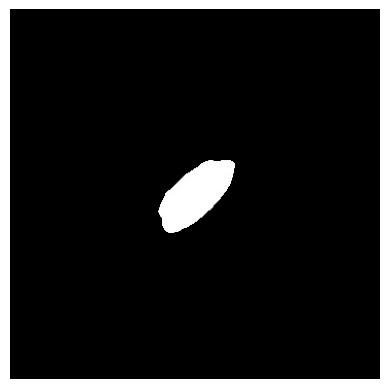

orginal image
img.shape (360, 360, 3)


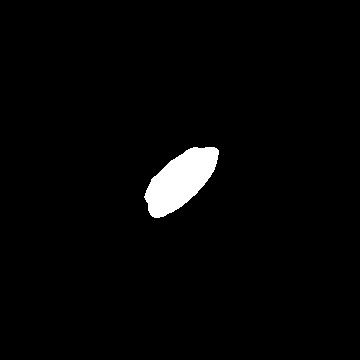

gray image
gray image.shape (360, 360)


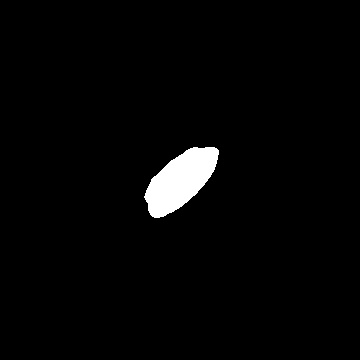

img converted to one column (129600,)
input image (360, 360)
gray image (129600,)
train_img.shape (360, 360)
train_df.shape (129600, 10)
the binary image
binary shape (360, 360)


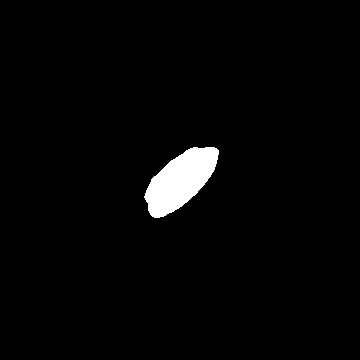

len main contours 1
cnt_area_list [2961.5]
all pores convexity [1.0263380043896675]
 Gas pore_com x 180
 Gas pore_com y 180
 LOF pore_com x 180
 LOF pore_com y 180
count the contour without child 0
count the contour with child 0
the annotated image
annotated_img shape (360, 360, 3)


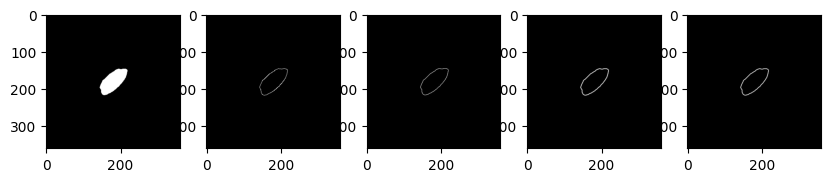

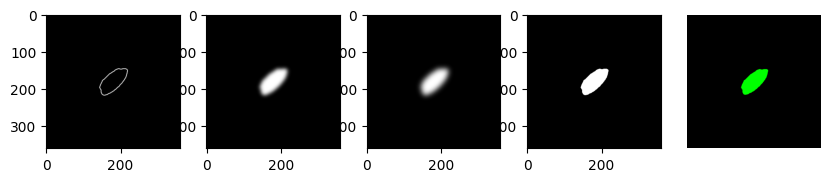

******* Add the labels variable then save the features and labels into csv file *******
labeled_img1 shape (129600,)
annotation shape (360, 360)
the unique labels [0 2]
the count of the unique labels 0    126733
2      2867
Name: Labels, dtype: int64
train_df.shape (129600, 11)
train_df         Original Image  Canny Edge  Roberts  Sobel  Scharr  Prewitt  \
0                    0           0      0.0    0.0     0.0      0.0   
1                    0           0      0.0    0.0     0.0      0.0   
2                    0           0      0.0    0.0     0.0      0.0   
3                    0           0      0.0    0.0     0.0      0.0   
4                    0           0      0.0    0.0     0.0      0.0   
...                ...         ...      ...    ...     ...      ...   
129595               0           0      0.0    0.0     0.0      0.0   
129596               0           0      0.0    0.0     0.0      0.0   
129597               0           0      0.0    0.0     0.0      0.0   
12

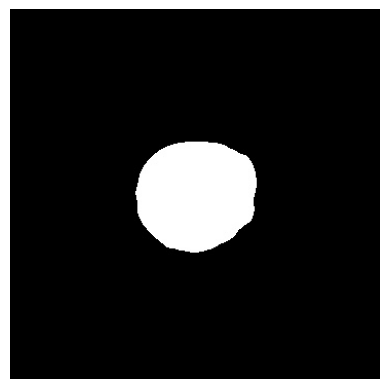

orginal image
img.shape (360, 360, 3)


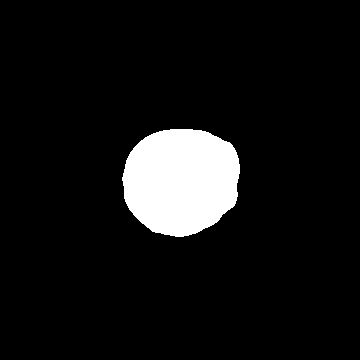

gray image
gray image.shape (360, 360)


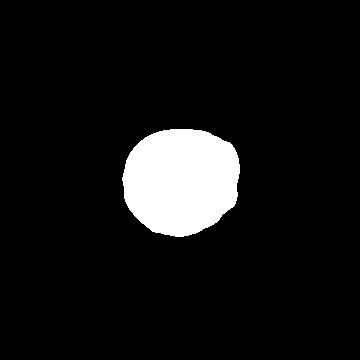

img converted to one column (129600,)
input image (360, 360)
gray image (129600,)
train_img.shape (360, 360)
train_df.shape (129600, 10)
the binary image
binary shape (360, 360)


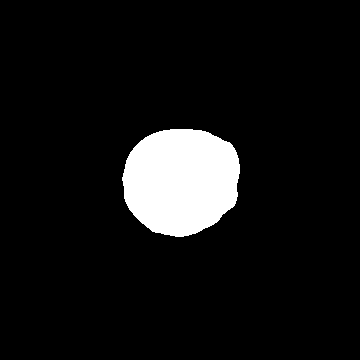

len main contours 1
cnt_area_list [9972.0]
all pores convexity [1.0141395908543922]
 Gas pore_com x 180
 Gas pore_com y 180
 LOF pore_com x 180
 LOF pore_com y 180
count the contour without child 0
count the contour with child 0
the annotated image
annotated_img shape (360, 360, 3)


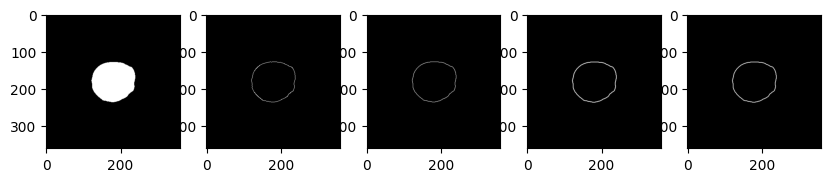

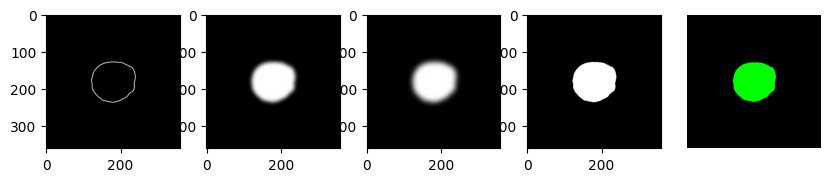

******* Add the labels variable then save the features and labels into csv file *******
labeled_img1 shape (129600,)
annotation shape (360, 360)
the unique labels [0 2]
the count of the unique labels 0    119791
2      9809
Name: Labels, dtype: int64
train_df.shape (129600, 11)
train_df         Original Image  Canny Edge  Roberts  Sobel  Scharr  Prewitt  \
0                    0           0      0.0    0.0     0.0      0.0   
1                    0           0      0.0    0.0     0.0      0.0   
2                    0           0      0.0    0.0     0.0      0.0   
3                    0           0      0.0    0.0     0.0      0.0   
4                    0           0      0.0    0.0     0.0      0.0   
...                ...         ...      ...    ...     ...      ...   
129595               0           0      0.0    0.0     0.0      0.0   
129596               0           0      0.0    0.0     0.0      0.0   
129597               0           0      0.0    0.0     0.0      0.0   
12

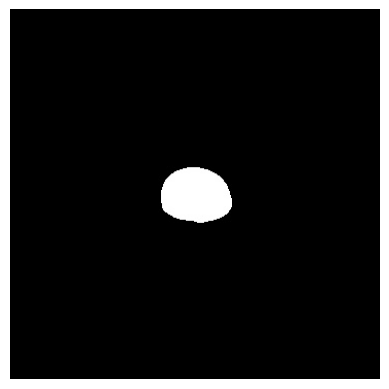

orginal image
img.shape (360, 360, 3)


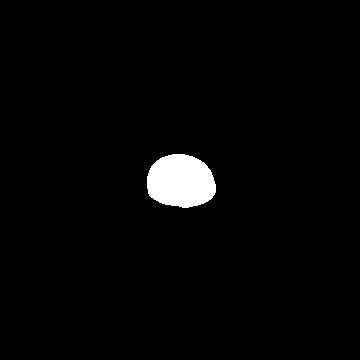

gray image
gray image.shape (360, 360)


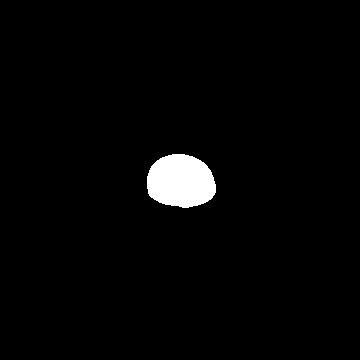

img converted to one column (129600,)
input image (360, 360)
gray image (129600,)
train_img.shape (360, 360)
train_df.shape (129600, 10)
the binary image
binary shape (360, 360)


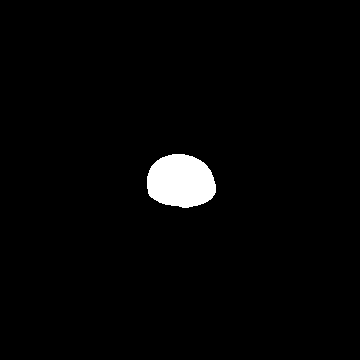

len main contours 1
cnt_area_list [2862.5]
all pores convexity [1.016768558951965]
 Gas pore_com x 180
 Gas pore_com y 180
 LOF pore_com x 180
 LOF pore_com y 180
count the contour without child 0
count the contour with child 0
the annotated image
annotated_img shape (360, 360, 3)


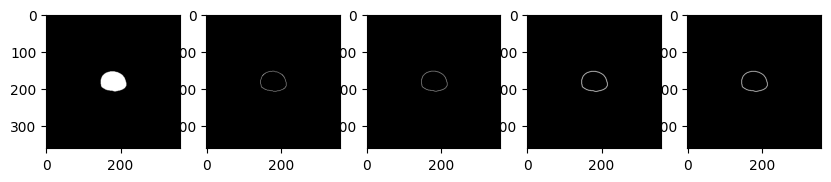

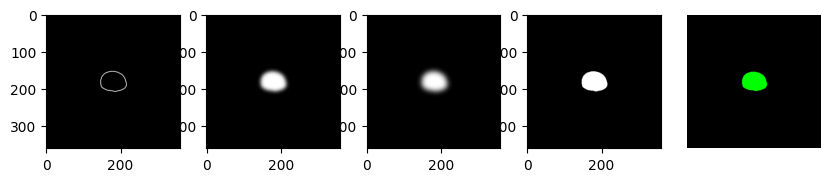

******* Add the labels variable then save the features and labels into csv file *******
labeled_img1 shape (129600,)
annotation shape (360, 360)
the unique labels [0 2]
the count of the unique labels 0    126826
2      2774
Name: Labels, dtype: int64
train_df.shape (129600, 11)
train_df         Original Image  Canny Edge  Roberts  Sobel  Scharr  Prewitt  \
0                    0           0      0.0    0.0     0.0      0.0   
1                    0           0      0.0    0.0     0.0      0.0   
2                    0           0      0.0    0.0     0.0      0.0   
3                    0           0      0.0    0.0     0.0      0.0   
4                    0           0      0.0    0.0     0.0      0.0   
...                ...         ...      ...    ...     ...      ...   
129595               0           0      0.0    0.0     0.0      0.0   
129596               0           0      0.0    0.0     0.0      0.0   
129597               0           0      0.0    0.0     0.0      0.0   
12

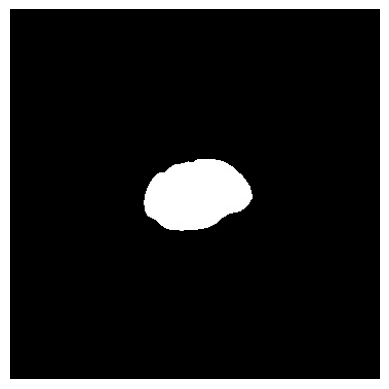

orginal image
img.shape (360, 360, 3)


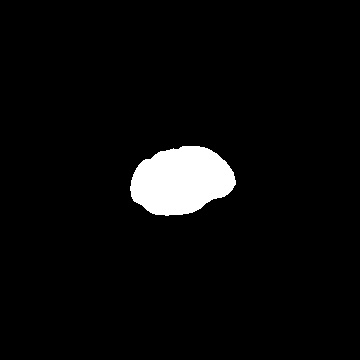

gray image
gray image.shape (360, 360)


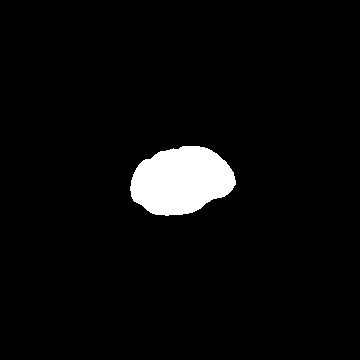

img converted to one column (129600,)
input image (360, 360)
gray image (129600,)
train_img.shape (360, 360)
train_df.shape (129600, 10)
the binary image
binary shape (360, 360)


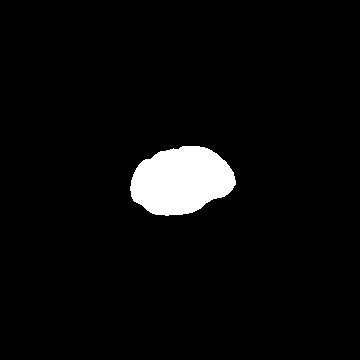

len main contours 1
cnt_area_list [5358.5]
all pores convexity [1.0271531212092937]
 Gas pore_com x 180
 Gas pore_com y 180
 LOF pore_com x 180
 LOF pore_com y 180
count the contour without child 0
count the contour with child 0
the annotated image
annotated_img shape (360, 360, 3)


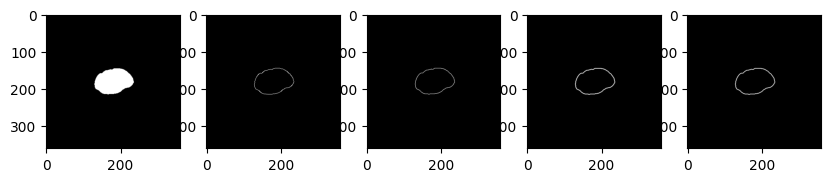

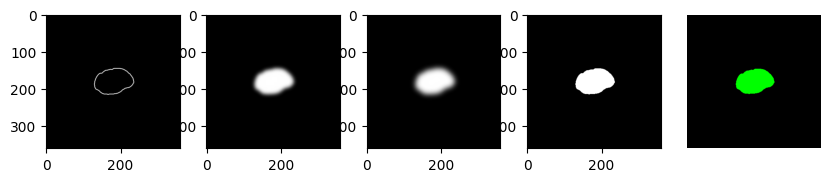

******* Add the labels variable then save the features and labels into csv file *******
labeled_img1 shape (129600,)
annotation shape (360, 360)
the unique labels [0 2]
the count of the unique labels 0    124365
2      5235
Name: Labels, dtype: int64
train_df.shape (129600, 11)
train_df         Original Image  Canny Edge  Roberts  Sobel  Scharr  Prewitt  \
0                    0           0      0.0    0.0     0.0      0.0   
1                    0           0      0.0    0.0     0.0      0.0   
2                    0           0      0.0    0.0     0.0      0.0   
3                    0           0      0.0    0.0     0.0      0.0   
4                    0           0      0.0    0.0     0.0      0.0   
...                ...         ...      ...    ...     ...      ...   
129595               0           0      0.0    0.0     0.0      0.0   
129596               0           0      0.0    0.0     0.0      0.0   
129597               0           0      0.0    0.0     0.0      0.0   
12

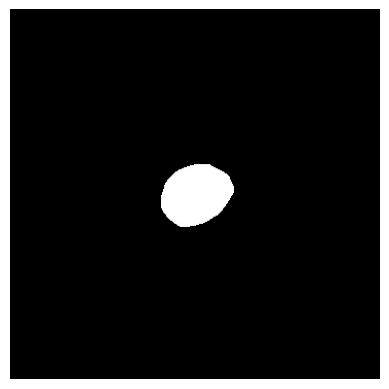

orginal image
img.shape (360, 360, 3)


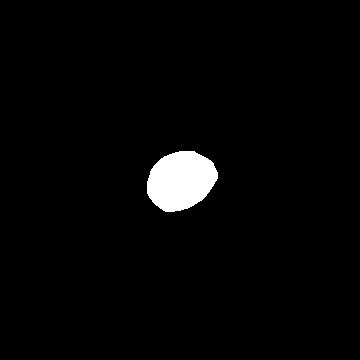

gray image
gray image.shape (360, 360)


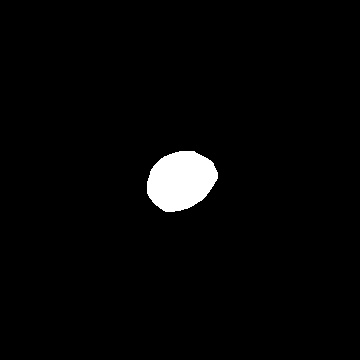

img converted to one column (129600,)
input image (360, 360)
gray image (129600,)
train_img.shape (360, 360)
train_df.shape (129600, 10)
the binary image
binary shape (360, 360)


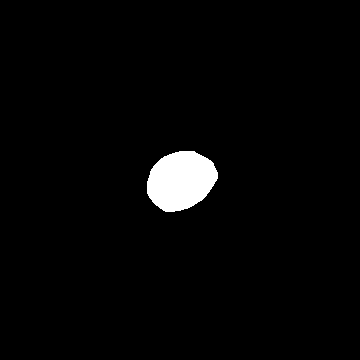

len main contours 1
cnt_area_list [3152.5]
all pores convexity [1.0144329896907216]
 Gas pore_com x 180
 Gas pore_com y 180
 LOF pore_com x 180
 LOF pore_com y 180
count the contour without child 0
count the contour with child 0
the annotated image
annotated_img shape (360, 360, 3)


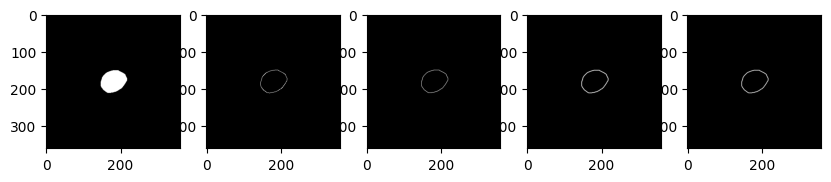

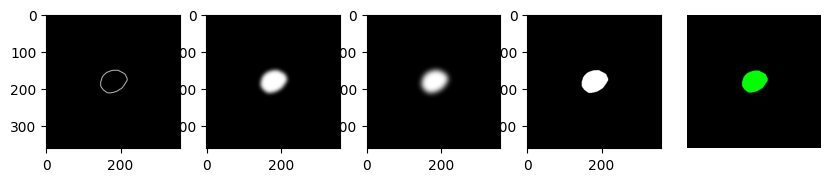

******* Add the labels variable then save the features and labels into csv file *******
labeled_img1 shape (129600,)
annotation shape (360, 360)
the unique labels [0 2]
the count of the unique labels 0    126537
2      3063
Name: Labels, dtype: int64
train_df.shape (129600, 11)
train_df         Original Image  Canny Edge  Roberts  Sobel  Scharr  Prewitt  \
0                    0           0      0.0    0.0     0.0      0.0   
1                    0           0      0.0    0.0     0.0      0.0   
2                    0           0      0.0    0.0     0.0      0.0   
3                    0           0      0.0    0.0     0.0      0.0   
4                    0           0      0.0    0.0     0.0      0.0   
...                ...         ...      ...    ...     ...      ...   
129595               0           0      0.0    0.0     0.0      0.0   
129596               0           0      0.0    0.0     0.0      0.0   
129597               0           0      0.0    0.0     0.0      0.0   
12

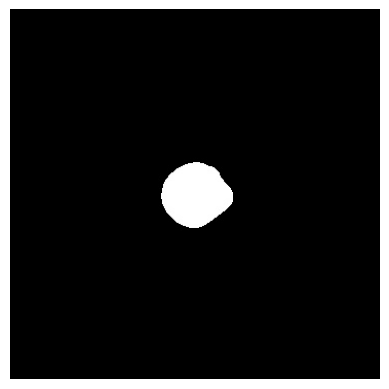

orginal image
img.shape (360, 360, 3)


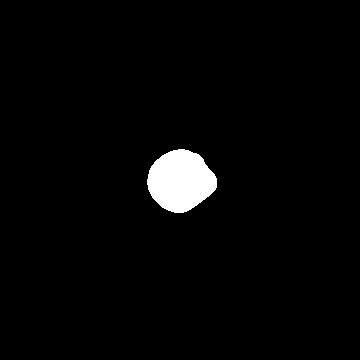

gray image
gray image.shape (360, 360)


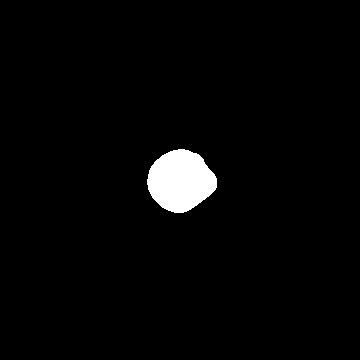

img converted to one column (129600,)
input image (360, 360)
gray image (129600,)
train_img.shape (360, 360)
train_df.shape (129600, 10)
the binary image
binary shape (360, 360)


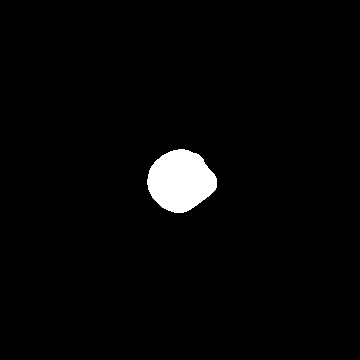

len main contours 1
cnt_area_list [3164.5]
all pores convexity [1.017064307157529]
 Gas pore_com x 180
 Gas pore_com y 180
 LOF pore_com x 180
 LOF pore_com y 180
count the contour without child 0
count the contour with child 0
the annotated image
annotated_img shape (360, 360, 3)


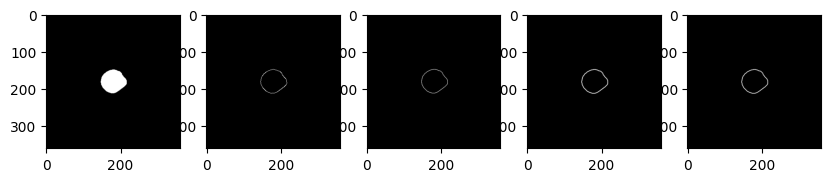

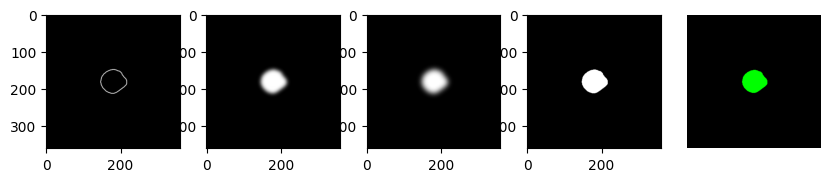

******* Add the labels variable then save the features and labels into csv file *******
labeled_img1 shape (129600,)
annotation shape (360, 360)
the unique labels [0 2]
the count of the unique labels 0    126523
2      3077
Name: Labels, dtype: int64
train_df.shape (129600, 11)
train_df         Original Image  Canny Edge  Roberts  Sobel  Scharr  Prewitt  \
0                    0           0      0.0    0.0     0.0      0.0   
1                    0           0      0.0    0.0     0.0      0.0   
2                    0           0      0.0    0.0     0.0      0.0   
3                    0           0      0.0    0.0     0.0      0.0   
4                    0           0      0.0    0.0     0.0      0.0   
...                ...         ...      ...    ...     ...      ...   
129595               0           0      0.0    0.0     0.0      0.0   
129596               0           0      0.0    0.0     0.0      0.0   
129597               0           0      0.0    0.0     0.0      0.0   
12

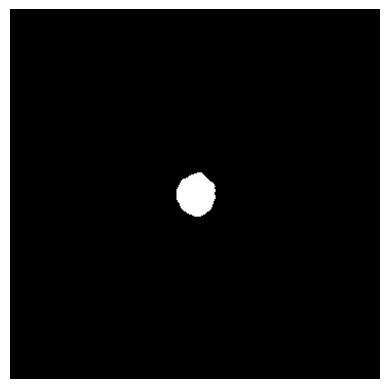

orginal image
img.shape (360, 360, 3)


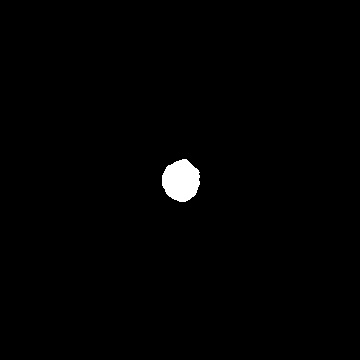

gray image
gray image.shape (360, 360)


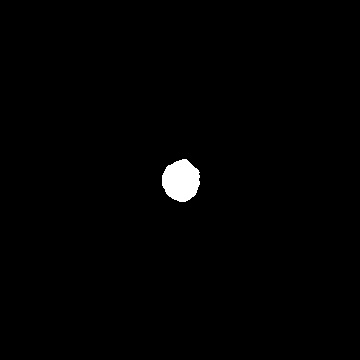

img converted to one column (129600,)
input image (360, 360)
gray image (129600,)
train_img.shape (360, 360)
train_df.shape (129600, 10)
the binary image
binary shape (360, 360)


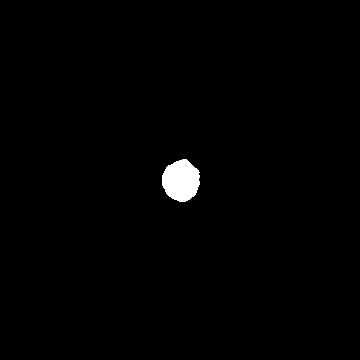

len main contours 1
cnt_area_list [1179.5]
all pores convexity [1.026282323018228]
 Gas pore_com x 180
 Gas pore_com y 180
 LOF pore_com x 180
 LOF pore_com y 180
count the contour without child 0
count the contour with child 0
the annotated image
annotated_img shape (360, 360, 3)


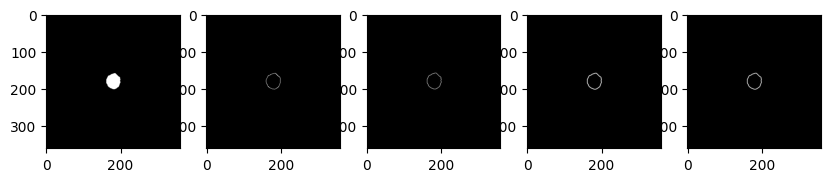

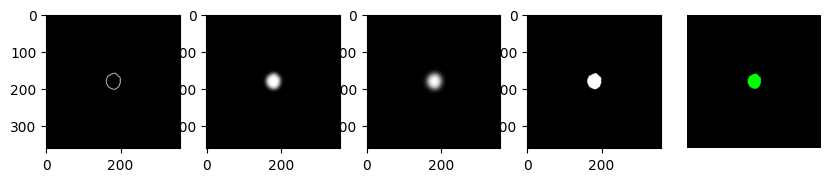

******* Add the labels variable then save the features and labels into csv file *******
labeled_img1 shape (129600,)
annotation shape (360, 360)
the unique labels [0 2]
the count of the unique labels 0    128475
2      1125
Name: Labels, dtype: int64
train_df.shape (129600, 11)
train_df         Original Image  Canny Edge  Roberts  Sobel  Scharr  Prewitt  \
0                    0           0      0.0    0.0     0.0      0.0   
1                    0           0      0.0    0.0     0.0      0.0   
2                    0           0      0.0    0.0     0.0      0.0   
3                    0           0      0.0    0.0     0.0      0.0   
4                    0           0      0.0    0.0     0.0      0.0   
...                ...         ...      ...    ...     ...      ...   
129595               0           0      0.0    0.0     0.0      0.0   
129596               0           0      0.0    0.0     0.0      0.0   
129597               0           0      0.0    0.0     0.0      0.0   
12

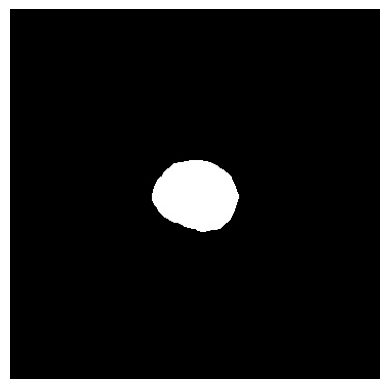

orginal image
img.shape (360, 360, 3)


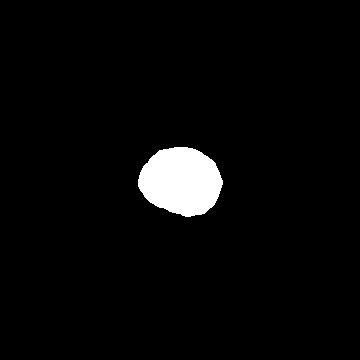

gray image
gray image.shape (360, 360)


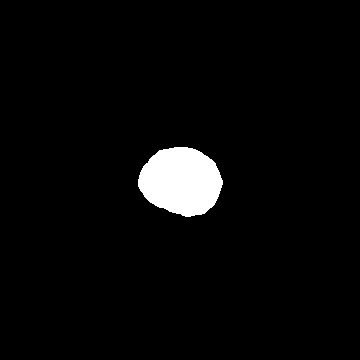

img converted to one column (129600,)
input image (360, 360)
gray image (129600,)
train_img.shape (360, 360)
train_df.shape (129600, 10)
the binary image
binary shape (360, 360)


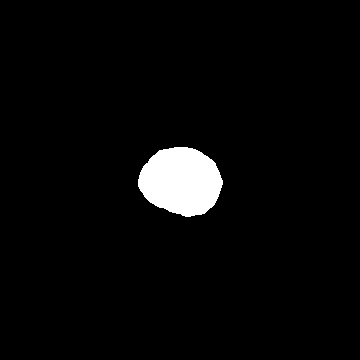

len main contours 1
cnt_area_list [4352.5]
all pores convexity [1.0172314761631247]
 Gas pore_com x 180
 Gas pore_com y 180
 LOF pore_com x 180
 LOF pore_com y 180
count the contour without child 0
count the contour with child 0
the annotated image
annotated_img shape (360, 360, 3)


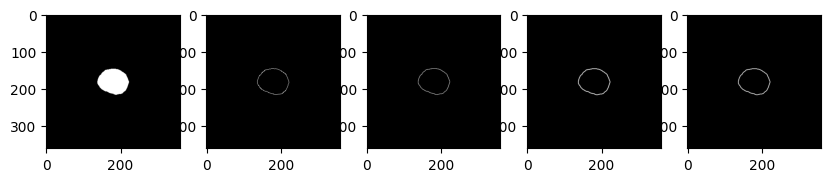

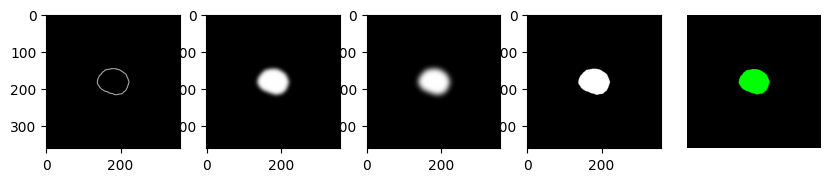

******* Add the labels variable then save the features and labels into csv file *******
labeled_img1 shape (129600,)
annotation shape (360, 360)
the unique labels [0 2]
the count of the unique labels 0    125354
2      4246
Name: Labels, dtype: int64
train_df.shape (129600, 11)
train_df         Original Image  Canny Edge  Roberts  Sobel  Scharr  Prewitt  \
0                    0           0      0.0    0.0     0.0      0.0   
1                    0           0      0.0    0.0     0.0      0.0   
2                    0           0      0.0    0.0     0.0      0.0   
3                    0           0      0.0    0.0     0.0      0.0   
4                    0           0      0.0    0.0     0.0      0.0   
...                ...         ...      ...    ...     ...      ...   
129595               0           0      0.0    0.0     0.0      0.0   
129596               0           0      0.0    0.0     0.0      0.0   
129597               0           0      0.0    0.0     0.0      0.0   
12

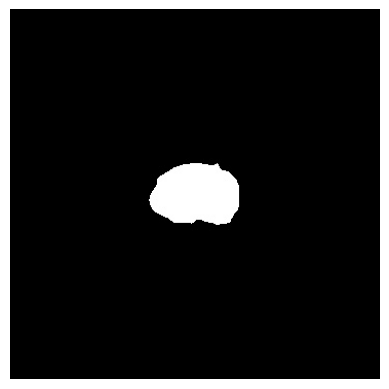

orginal image
img.shape (360, 360, 3)


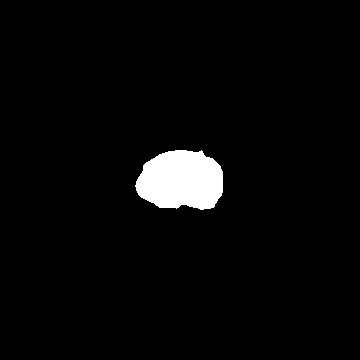

gray image
gray image.shape (360, 360)


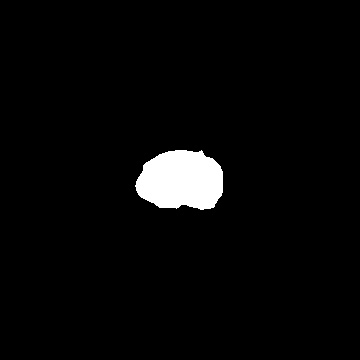

img converted to one column (129600,)
input image (360, 360)
gray image (129600,)
train_img.shape (360, 360)
train_df.shape (129600, 10)
the binary image
binary shape (360, 360)


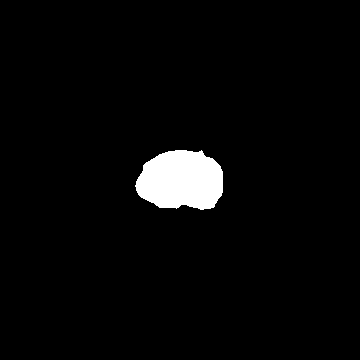

len main contours 1
cnt_area_list [4077.0]
all pores convexity [1.0416973264655385]
 Gas pore_com x 180
 Gas pore_com y 180
 LOF pore_com x 180
 LOF pore_com y 180
count the contour without child 0
count the contour with child 0
the annotated image
annotated_img shape (360, 360, 3)


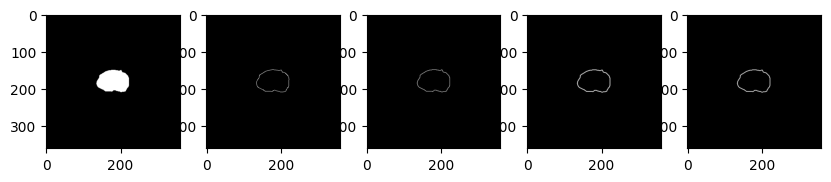

In [ ]:

## in case we have multi images for train:

# Directory containing the images
image_dir = "/content/train_images"
print('image_dir',image_dir)

# New directory for saving results
output_dir = "/content/labeled_and_predicted_images_and_results"
os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

images_dataset = pd.DataFrame()

# Loop over the files in the directory
for image_file in os.listdir(image_dir):
  print('image_file',image_file)
  if image_file != '.ipynb_checkpoints':
    # Load the image
    img = cv2.imread(os.path.join(image_dir, image_file))

    # input_image = img[:, 430:1490]  ## croped image used with only our data images   img.shape (1080, 1060, 3)
    # input_image = input_image[45:1035,:]  ## croped image used with only our data images  img.shape (990, 1060, 3)

    input_image = img

    plt.imshow(input_image)
    plt.axis('off')
    plt.show()

    train_img, train_df = extract_pixel_features(input_image)
    print('train_img.shape',train_img.shape)
    # print('train_img_org.shape',train_img_org.shape)
    print('train_df.shape',train_df.shape)

    #############################
    #Update dataframe for images to include details for each image in the loop
    #train_df = pd.DataFrame(train_df)

    train_output_labeled_image_path ='{}/labeled_train_image_{}'.format(output_dir,image_file)
    # statistics_features_path ='{}/statistics_features_image_{}'.format(output_dir,image_file)

    train_df_labeled, cnt_area_list, area, solidity, convexity, pore_circularities, unique_list = label_image(train_img, input_image, train_output_labeled_image_path,train_features_path, train_df)
    ##label_image(train_img, train_img_org, train_output_labeled_image_path,train_features_path, train_df)

    # print('count_process', len(count_process))
    # print('count_keyhole', len(count_keyhole))
    # print('count_LOF', len(count_LOF))
    ############################
    # Concatenate the rows of df of the images
    images_dataset = pd.concat([images_dataset, train_df_labeled], axis=0)
    # Reset the index of the result DataFrame to have continuous integer indices
    images_dataset = images_dataset.reset_index(drop=True)
    print('train_df.shape',train_df.shape)
    print('train_df',train_df)

    print('images_dataset.shape',images_dataset.shape)
    print('images_dataset',images_dataset)
    print('unique_lists', unique_list)
    ########################

      ##  area, convexity, solidity,pore_circularities, image_file
    df_over_all_images = pd.DataFrame({"image" : [image_file],
                                      #  "cnt_area_list?" : [cnt_area_list],
                                      "area" : [area],
                                      "solidity" : [solidity],
                                      "circularity" : [pore_circularities],
                                      "convexity" : [convexity]
                                      })
    df_over_all_images.to_csv("geometry_features_over_all_images.csv", index=False, mode='a', header=False)
    ########################################################################################################################
    df_unique_list = pd.DataFrame({"image" : [image_file],
                                      #  "cnt_area_list?" : [cnt_area_list],
                                      "unique_list" : [unique_list]
                                      })
    df_unique_list.to_csv("unique_list_over_all_images.csv", index=False, mode='a', header=False)





In [33]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv("/content/unique_list_over_all_images.csv")
# labels = df[ 'labels']

# Create a dictionary to store the summation of each unique label
label_sum = {}

# Loop through the 'labels' column and update the dictionary
for row in df['labels']:
    labels = [int(label) for label in row.strip('[]').split()]
    for label in labels:
        if label in label_sum:
            label_sum[label] += 1
        else:
            label_sum[label] = 1

# Print the results
for label, summation in label_sum.items():
    print(f'summation of the unique label {label} = {summation}')



summation of the unique label 0 = 6
summation of the unique label 4 = 2
summation of the unique label 1 = 3
summation of the unique label 2 = 2


mean area_convexit,solidity_circularity :  6996.21  ,  0.763  ,  0.433  ,  1.366
min area_convexit,solidity_circularity :  2.0  ,  0.328  ,  0.129  ,  1.0
max area_convexit,solidity_circularity :  57660.5  ,  1.0  ,  0.925  ,  3.045
var area_convexit,solidity_circularity :  100911861.203  ,  0.021  ,  0.04  ,  0.092
std area_convexit,solidity_circularity :  10045.49  ,  0.146  ,  0.2  ,  0.303


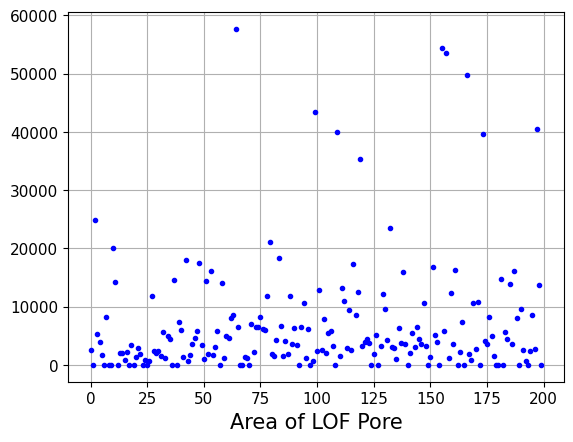

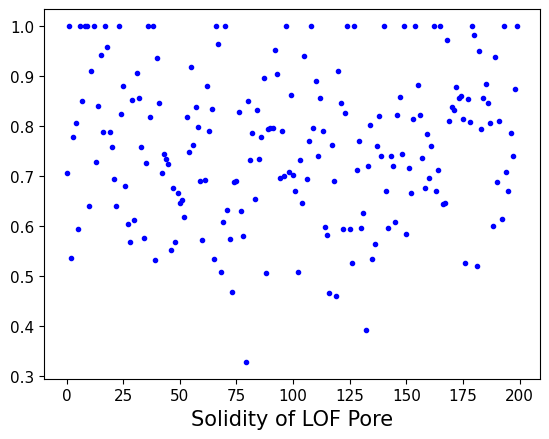

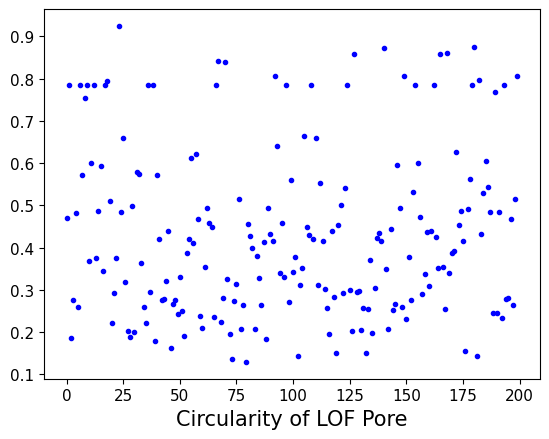

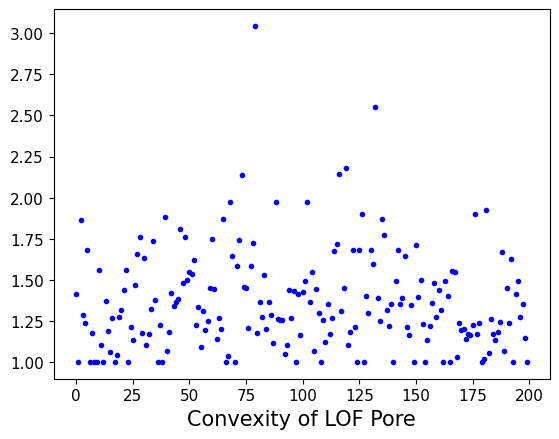

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/LOF_geometry_features_over_all_images.csv")

area = results[ 'area']
solidity = results[ 'solidity']
circularity = results[ 'circularity']
convexity = results[ 'convexity']
print('mean area_convexit,solidity_circularity : ', round(np.mean(area),3),' , ',round(np.mean(solidity),3),' , ',round(np.mean(circularity),3),' , ',round(np.mean(convexity),3))
print('min area_convexit,solidity_circularity : ',round(np.min(area),3),' , ',round(np.min(solidity),3),' , ',round(np.min(circularity),3),' , ',round(np.min(convexity),3))
print('max area_convexit,solidity_circularity : ',round(np.max(area),3),' , ',round(np.max(solidity),3),' , ',round(np.max(circularity),3),' , ',round(np.max(convexity),3))
print('var area_convexit,solidity_circularity : ',round(np.var(area),3),' , ',round(np.var(solidity),3),' , ',round(np.var(circularity),3),' , ',round(np.var(convexity),3))
print('std area_convexit,solidity_circularity : ',round(np.std(area),3),' , ',round(np.std(solidity),3),' , ',round(np.std(circularity),3),' , ',round(np.std(convexity),3))


plt.plot(area, '.b')
plt.xlabel('Area of LOF Pore', fontsize=15)
plt.show()

plt.plot(solidity, '.b')
plt.xlabel('Solidity of LOF Pore', fontsize=15)
plt.show()

plt.plot(circularity, '.b')
plt.xlabel('Circularity of LOF Pore', fontsize=15)
plt.show()

plt.plot(convexity, '.b')
plt.xlabel('Convexity of LOF Pore', fontsize=15)
plt.show()

  # # #plt.legend(loc='center')
  # # #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  # # # plt.savefig("/content/pore_count_directions/count_direction_against_{}.jpg".format(col[0:5]))
  # plt.show()

# This is formatted as code

In [35]:
# %rm -rf '/content/labeled_and_predicted_images_and_results'
